I've been taking part in the [Google Landmark Retrieval 2020](https://www.kaggle.com/c/landmark-retrieval-2020) competition recently which has 1.5 million images in its training dataset. To have any chance of training a good model on even a fraction of these images inside a Kaggle notebook I found that I needed a TPU. As such I have had a look around other notebooks and worked out how to convert images into tfrecords. In this format the images enable TPU training at much faster speeds.

Note that I am using triplet loss in this competition to train a model. As such I have arranged the tfrecords to contain triplets of images. However if you want to create a tfrecord dataset without triplets you can still fork this notebook. I have highlighted at the appropriate code block what you would need to change.

If you'd like to see how to use this dataset to train a model, you can see how I've used it in this [notebook](https://www.kaggle.com/mattbast/google-landmark-retrieval-triplet-loss).

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm

## Load dataset

First thing to do is to arrange the dataset into triplets. I'll start with the table of meta information about the images. It includes the image ids (which also includes the directory location of the image) and the id of the landmark in the image.

In [ ]:
all_images_meta = pd.read_csv('../input/landmark-retrieval-2020/train.csv')

While I would like to convert all the images into tfrecords I am limited in that Kaggle notebooks only allow for 4.9GB of output (the landmarks dataset before it is converted to tfrecords is around 100GB large). I thus need to take a representative sample of the data. I decided that it would be better to get at least one image of every landmark in the dataset. This would help the model generalise better to various styles of architecture. 

A quick way to do this is to group by landmark, get the first two images per group and then reset the index to get the table back to the right shape.

In [ ]:
images_meta_sample = all_images_meta.groupby('landmark_id').head(2).reset_index(drop=True)

In [ ]:
images_meta_sample.head(10)

In [ ]:
images_meta_sample.info()

## Form triplets

For those new to triplet loss, here's a short description of what it means. Models will use triplet loss when they are trying to produce an embedding for an image. An embedding is an array of numbers that represents what is included in the image. Think of it like a textual description such as "this image includes landmark x on a sunny day" except this text is in a number format that the machine understands. These embeddings can then be compared using a clustering algorithm when a machine is trying to work out if two images contain the same monument.

Triplet loss enables this by looking at images in threes. One image is an anchor and can include any landmark in it. The next is the positive image. This image must contain the same landmark as the anchor. Finally there is the negative image that contains a different landmark. The purpose then is to minimise the difference between the anchor and positive embeddings while maximising the distance between the anchor and the negative embeddings.

The dataset then needs to form these sets of three. Let's begin by organising the images into the groups by their landmark ids.

In [ ]:
landmark_groups = all_images_meta.groupby('landmark_id')

And have a look at one of those groups.

In [ ]:
landmark_group = landmark_groups.get_group(1)
landmark_group

Then get a random positive image. This function randomly picks an image from the group of images that contain the same landmark as the anchor. This may pick the same image as the anchor. However it saves some time as this is a fast way to perform the operation on a large dataset.

In [ ]:
def get_positive(anchor_landmark_id):    
    landmark_group = landmark_groups.get_group(anchor_landmark_id)
    indexes = landmark_group.index.values
    
    rand_index = np.random.choice(indexes)
    pos_img_id = landmark_group.loc[rand_index].id
        
    return pos_img_id

In [ ]:
images_meta_sample['positive_id'] = images_meta_sample['landmark_id'].apply(get_positive)

Then get a negative image. This time get a list of all the image indexes and randomly pick one. If this image does not contain the same landmark as the anchor use it as the negative. Otherwise repeat this process until an image not in the same landmark group is found.

In [ ]:
def get_negative(landmark_id):        
    indexes = images_meta_sample.index.values
    
    for i in range(len(images_meta_sample)):
        rand_index = np.random.choice(indexes)
        
        neg_img_id = images_meta_sample.loc[rand_index].id
        neg_landmark_id = images_meta_sample.loc[rand_index].landmark_id
        
        if neg_landmark_id != landmark_id:
            return neg_img_id
    
    return neg_img_id

In [ ]:
images_meta_sample['negative_id'] = images_meta_sample['landmark_id'].apply(get_negative)

We now have a list of anchor images with a positive and negative image next to each one. I've also renamed the id column to anchor_id to remind me that this column contains the id of the anchor image.

In [ ]:
images_meta_sample = images_meta_sample.rename({'id': 'anchor_id'}, axis='columns')

In [ ]:
images_meta_sample.head()

## Write to tfrecords

With the dataset organised it's time to start writing the images to tfrecords. I wanted to quickly explain my understanding of what a tfrecord is before getting into how to create them as it took me a while to work it out.

A tfrecord is a file that contains many examples of a dataset. So for most image related tasks an example would contain one image and probably some sort of label. In this task I have included three images (a triplet) in each example. Each image is also formatted as a byte string rather than an image or numpy array.

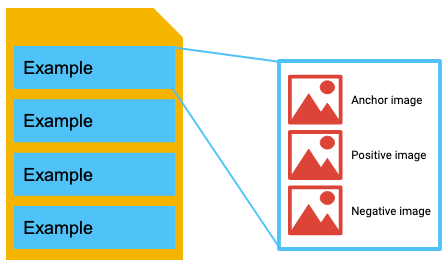

Formatting the data in this way helps tensorflow to distribute and cache the data. It also reduces the time it takes to transfer images to the google cloud bucket sitting next to a TPU. This is because we are transferring many examples bundled into one file rather than one image example at a time.

So to start I'll define a function to convert an image into a byte string.

In [ ]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

and a function that loads an image from the dataset and encodes it ready for the bytes feature function. Note that the dataset is split into many directories and sub directories. The first three characters of an images id specify the directory path that the image lives in.

It is also here that I can reduce the size of the tfrecord files. As mentioned before, Kaggle notebooks only allow 4.9GBs of data to be outputted so the images sample needs to be reduced here so to fit as many images as possible into the tfrecord files. I've opted for a size of 128,128 using the nearest neighbour method of resizing.

In [ ]:
def get_image(img_id):
    chars = tf.strings.bytes_split(img_id)
    dir_1, dir_2, dir_3 = chars[0], chars[1], chars[2]
    
    path = '../input/landmark-retrieval-2020/train/' + dir_1 + '/' + dir_2 + '/' + dir_3 + '/' + img_id + '.jpg'
    image = tf.io.read_file(path)
    
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, size=(128, 128), method='nearest')
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    image = tf.image.encode_jpeg(image, quality=94, optimize_size=True)
    
    return image

Finally group these two helped functions together to form one example containing a triplet of images.

In [ ]:
def serialize_example(example):    
    anchor_img = get_image(example.anchor_id)
    positive_img = get_image(example.positive_id)
    negative_img = get_image(example.negative_id)
    
    feature = {
        'anchor_img': _bytes_feature(anchor_img),
        'positive_img': _bytes_feature(positive_img),
        'negative_img': _bytes_feature(negative_img),
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

Now get a list of the example indexes (remember that each example contains three images).

In [ ]:
image_indexes = images_meta_sample.index.values

And define the size and number of tfrecord files to create. I've heard 15 is a good number to aim for though honestly I'm still working out the best way to decide on the number of files to create. For now them I'll split the examples into 15 files.

In [ ]:
file_size = len(image_indexes) // 15
file_count = len(image_indexes) // file_size + int(len(image_indexes) % file_size != 0)

Here's another helper function that takes a subset of the examples indexes, loads the examples and writes them to a file.

In [ ]:
def write_tfrecord_file(file_index, file_size, image_indexes):
    with tf.io.TFRecordWriter('train%.2i.tfrec'%(file_index)) as writer:
        start = file_size * file_index
        end = file_size * (file_index + 1)
        
        for i in tqdm(image_indexes[start:end]):

            example = serialize_example(
                images_meta_sample.loc[i]
            )
            
            writer.write(example)

Finally bring everything together. Loop through the subsets of indexes and write a file for each subset.

In [ ]:
for file_index in range(file_count):
    print('Writing TFRecord %i of %i...'%(file_index, file_count))
    write_tfrecord_file(file_index, file_size, image_indexes)

## Conclusion

To use these tfrecrds you will need to turn the output of this notebook into a public dataset. Simply commit the notebook, scroll to the bottom of the published notebook and click create dataset next to the notebook output. Once that is done you can do something like [this](https://www.kaggle.com/mattbast/google-landmark-retrieval-triplet-loss) to use your shiny new tfrecords.

I think it is worth noting here that this is not the perfect solution to the super large dataset that comes with this challenge. If you take one image per unique landmark id you'll be left with 81k images out of the the total 1.5 million. That's a very small sample compared to the total size. This will certainly help you quickly train a model with many images but keep in mind the limitations of the size of this notebooks output vs the total size of the raw data.